In [2]:
''' 
This ipynb notebook shows the statistics and the data visualization of the MovieLens 1M dataset
@author RaaghavvDevgon
'''


import random
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse import csr_matrix
from sklearn import metrics
import matplotlib.pylab as plt
import seaborn as sns
from numpy.linalg import solve

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-12-14 05:58:49--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  18.2MB/s    in 0.3s    

2021-12-14 05:58:50 (18.2 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [6]:
data = pd.read_csv('./ml-1m/ratings.dat', sep = '::', header = None, encoding = 'latin-1', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('./ml-1m/movies.dat', sep = '::', header = None, encoding = 'latin-1', names=['movie_id', 'movie', 'genre'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [11]:
movies.head()

,movie_id,movie,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


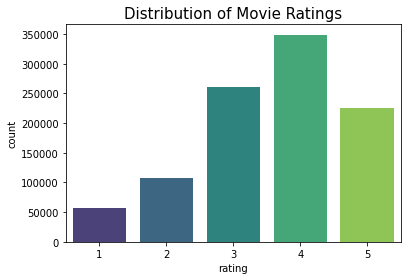

In [7]:
'''
Distribution of Movie ratings based on the movie databae.
'''
sns.countplot(x="rating",data=data,palette="viridis")
plt.title("Distribution of Movie Ratings",fontsize=15)
plt.show()

In [8]:
''' 
Generate Movie Stats
'''
movie_stats = data.groupby('movie_id')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [9]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()
''' 
Calculating bayesian average
'''

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = data.groupby('movie_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movie_id', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movie_id')

In [10]:
movie_stats['movie_id']=movie_stats['movie_id'].astype(int)

In [13]:
movie_stats = movie_stats.merge(movies[['movie_id', 'movie']])

In [15]:
''' 
Lowest Rated movies
'''

movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movie_id,count,mean,bayesian_avg,movie
3353,3593,342,1.611111,2.329085,Battlefield Earth (2000)
2496,2701,902,2.158537,2.407345,Wild Wild West (1999)
1432,1556,367,1.871935,2.451199,Speed 2: Cruise Control (1997)
532,546,350,1.874286,2.468412,Super Mario Bros. (1993)
2441,2643,332,1.888554,2.494050,Superman IV: The Quest for Peace (1987)


In [16]:
''' 
Highest Rated movies
'''

movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movie_id,count,mean,bayesian_avg,movie
309,318,2227,4.554558,4.412347,"Shawshank Redemption, The (1994)"
802,858,2223,4.524966,4.385731,"Godfather, The (1972)"
513,527,2304,4.510417,4.377089,Schindler's List (1993)
1108,1198,2514,4.477725,4.357624,Raiders of the Lost Ark (1981)
253,260,2991,4.453694,4.353151,Star Wars: Episode IV - A New Hope (1977)


In [17]:
users = data['user_id'].unique() #list of all unique users
movies = data['movie_id'].unique() #list of all unique movies

In [18]:
def createUtilityMatrix(X,userAll,moviesAll):
    M=len(userAll)
    N=len(moviesAll)
    user_dict=dict(zip(userAll,list(range(M))))
    movie_dict=dict(zip(moviesAll,list(range(N))))
    user_index = [user_dict[i] for i in X['user_id']]
    item_index = [movie_dict[i] for i in X['movie_id']]
    mat = csr_matrix((X["rating"], (user_index,item_index)), shape=(M,N))
    return mat, user_dict,movie_dict


data_matrix,u_dict,movie_dict=createUtilityMatrix(data,users,movies)


In [19]:
''' 
Calculating sparsity of matrix
'''
n_total = data_matrix.shape[0]*data_matrix.shape[1]
n_ratings = data_matrix.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 4.47%


In [20]:
n_ratings_per_user = data_matrix.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

n_ratings_per_movie = data_matrix.getnnz(axis=0)

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most active user rated 2314 movies.
Least active user rated 20 movies.
Most rated movie has 3428 ratings.
Least rated movie has 1 ratings.


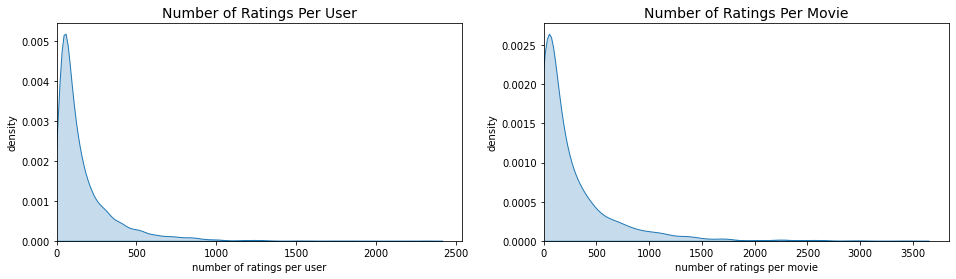

In [21]:


plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()